In [6]:
import numpy as np
import xarray as xr
import pandas as pd

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy
import seaborn as sns

from global_land_mask import globe

from scipy.stats import boxcox
import random

from sklearn.cluster import KMeans
from sklearn.cross_decomposition import CCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, normalized_mutual_info_score, adjusted_rand_score

from sklearn.metrics import mean_squared_error

import clustering_functions as cf
import skill_scores as sc

import xesmf as xe

In [7]:
g0 = 9.80665
extended_winter_months = [11, 12, 1, 2, 3]

## Data pre-processing

**z500 - Atlantic**

In [8]:
z500 = cf.preprocess_dataset(filename = '../data.nosync/era5_z500_daily_250_atlantic_1940_2022.nc',
                              variable_name = 'z', 
                              multiplication_factor = 1/g0, 
                              geographical_filter = 'new atlantic', 
                              months_filter = extended_winter_months, 
                              anomalies = True, 
                              normalization = False,
                              rolling_window = 5)

z500 = z500.where(z500['time.year'] > 1980, drop=True)
z500 = z500.where(z500['time.year'] < 2023, drop=True)


weights = np.cos(np.deg2rad(z500.latitude))
z500 = z500*weights
z500 = z500/z500.std()

z500_reshaped = cf.reshape_data_for_clustering(z500)

**precipitation**

In [9]:
pr_labels = pd.read_csv('../data.nosync/CHIRPS_pr_cluster_labels_5.csv')
pr_labels.columns = ['index', 'labels']
pr_labels.drop(pr_labels.tail(1).index,inplace=True)

pr_labels['values']=[1]*len(pr_labels)
label_indices_pd = pd.pivot_table(pr_labels, values='values', index=['index'],
                    columns=['labels'], aggfunc=np.sum).fillna(0)
label_indices = label_indices_pd.values

threshold_qn95 = xr.open_dataset('../data.nosync/CHIRPS_pr_95pc_EW.nc')
threshold_qn95 = threshold_qn95.where(threshold_qn95['time.year'] < 2023, drop=True)['precipitation_amount']

pr_spatial = xr.open_dataset('../data.nosync/CHIRPS_pr_total_EW.nc')['precipitation_amount']
pr_spatial = pr_spatial.where(pr_spatial['time.year'] < 2023, drop=True)

pr = xr.open_dataset('../data.nosync/CHIRPS_pr_EW.nc')['precipitation_amount']
pr = pr.where(pr['time.year'] < 2023, drop=True)

pr_zeros = pr.fillna(0)

# PCA+kmeans

In [6]:
pc_number=15

In [7]:
filepath_pca_kmeans='results.nosync/model_specifications_and_results/pca_kmeans/v924/'

In [8]:
eofs_z500, variance_fraction_z500, pcs_z500, reconstruction_z500 = cf.eof_analysis(z500, pc_number)
d = {'Metric': ['Variance Fraction'], 'Value': sum(variance_fraction_z500[0:pc_number]).values}
df = pd.DataFrame(data=d)
df.to_csv(filepath_pca_kmeans+'variance_fraction.csv')

In [9]:
reconstructed_pca = pcs_z500[:, 0]*eofs_z500[0, :, :]
for i in range(pc_number):
    reconstructed_pca = reconstructed_pca+pcs_z500[:, i]*eofs_z500[i, :, :]

nt,ny,nx = z500.values.shape
z500_reshaped = np.reshape(z500.values, [nt, ny*nx], order='F')
reconstructed_reshaped = np.reshape(reconstructed_pca.values, [nt, ny*nx], order='F')

mse = mean_squared_error(reconstructed_reshaped, z500_reshaped, multioutput='raw_values')
d = {'MSE': 'PCA', 'Value': mse}
df = pd.DataFrame(data=d)
df.to_csv(filepath_pca_kmeans+'mse.csv')

4
5
6
7
8
9
10


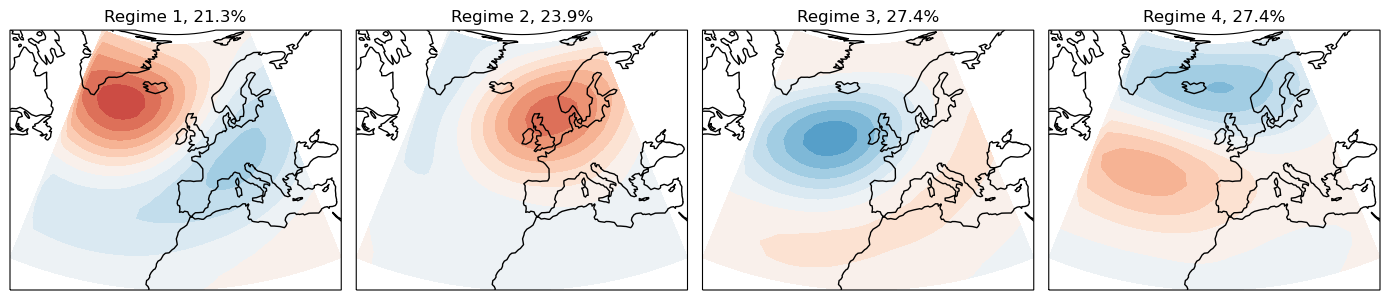

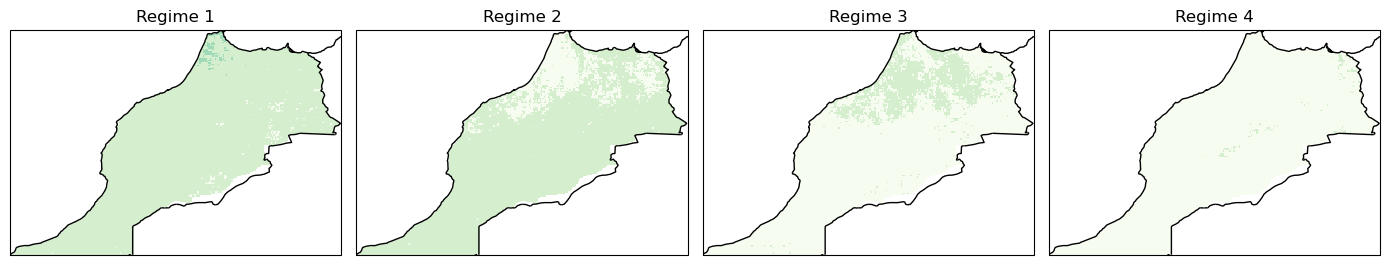

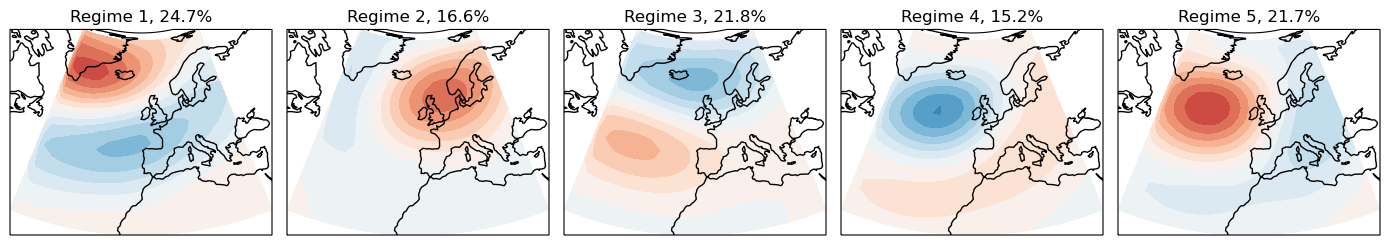

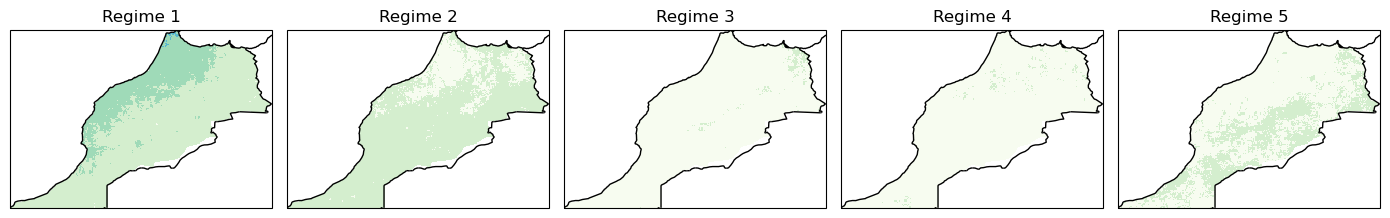

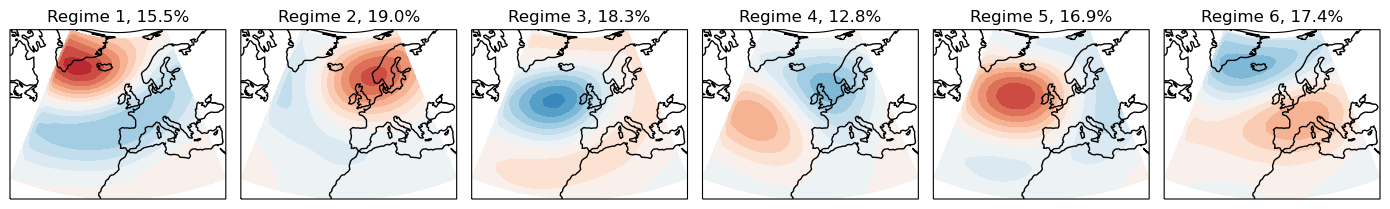

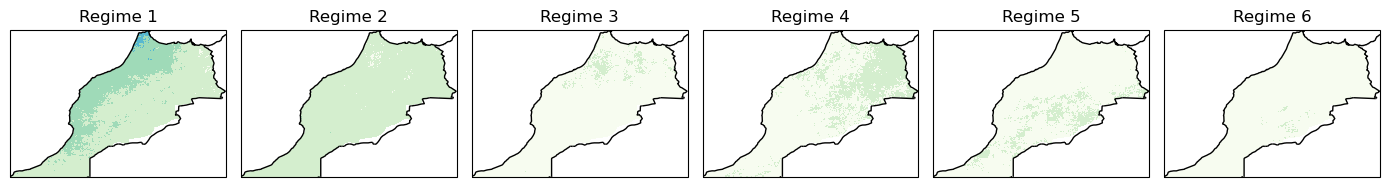

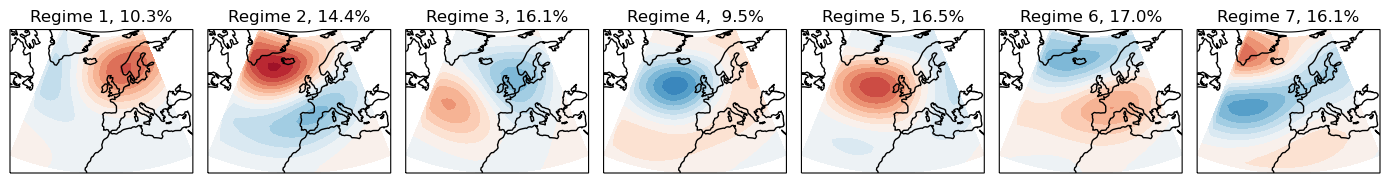

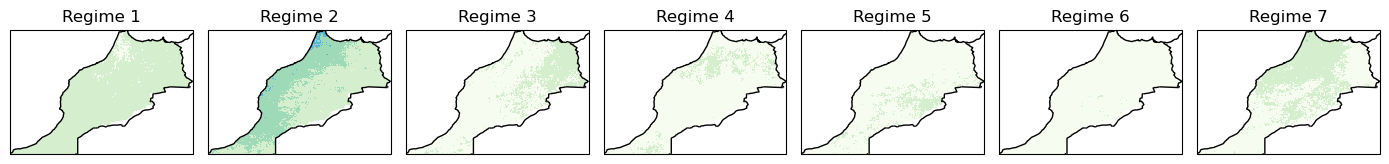

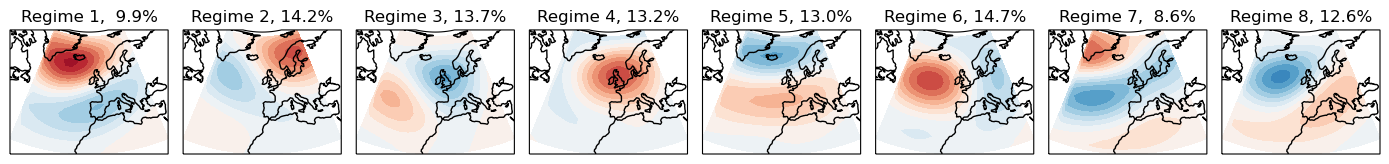

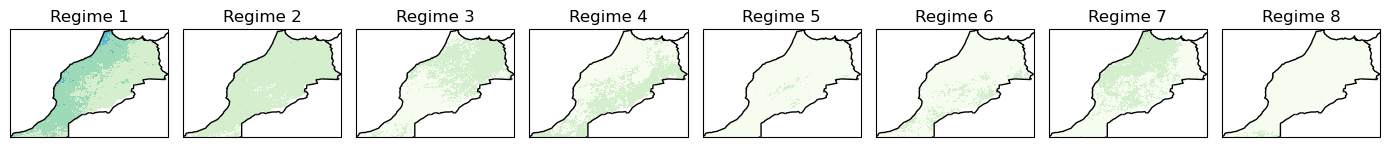

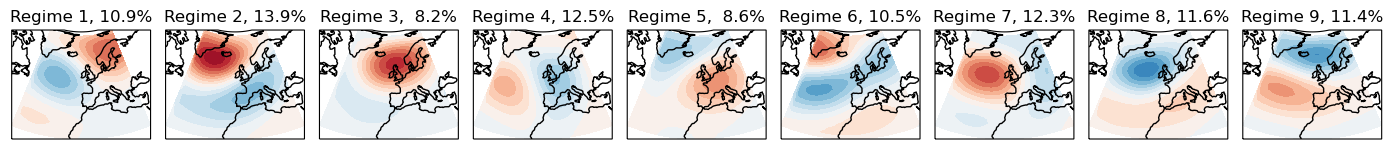

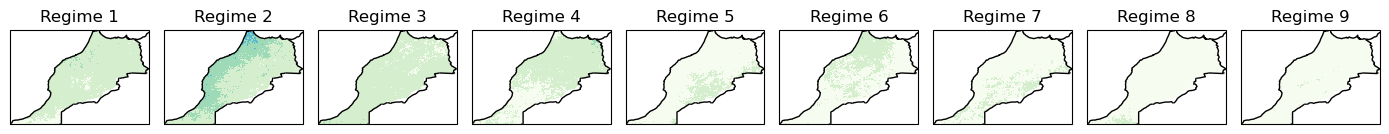

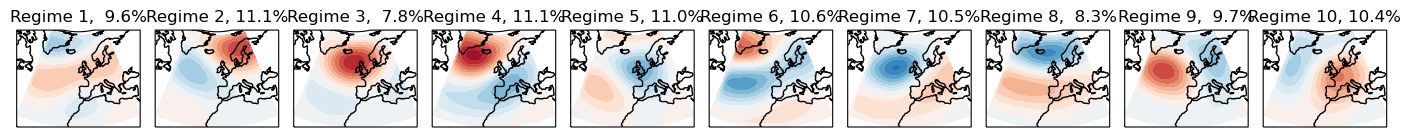

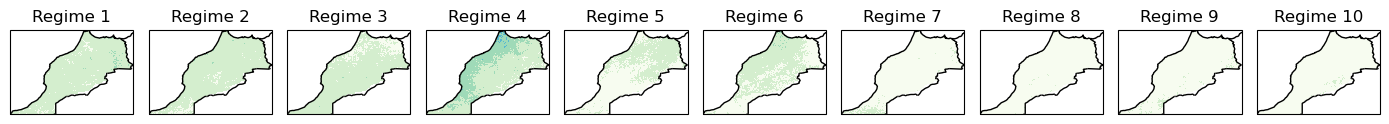

In [46]:
#for k in [4]:
for k in [4, 5, 6, 7, 8, 9, 10]:
    
    print(k)
    
    # calculate clusters and centroids
    pca_clusters = KMeans(n_clusters=k, n_init=50, random_state=0).fit(pcs_z500)
    
    # reorder labels
    precip_sum = pd.DataFrame(pr_spatial.values).groupby(pca_clusters.labels_).sum().reset_index()
    precip_sum['index']=precip_sum['index'].astype('int')
    precip_sum = precip_sum.rename(columns={"index": "index_old"})
    precip_sum = precip_sum.sort_values(by=0, ascending=False)
    precip_sum['index_new'] = np.arange(precip_sum.shape[0])

    labels_reordered = pca_clusters.labels_.copy()
    for i in range(len(pca_clusters.labels_)):
        new_label = precip_sum[precip_sum['index_old']==pca_clusters.labels_[i].astype('int')]['index_new'].values[0]
        labels_reordered[i] = new_label
    
    # save cluster centers
    centroids_preciporder = pca_clusters.cluster_centers_[precip_sum['index_old'].values.tolist(), :]
    
    centroids_pca_preciporder = cf.reshape_centroids(k=k, kmeans_centers = centroids_preciporder, eofs = eofs_z500, pc_number = pc_number)
    centroids_pca = cf.reshape_centroids(k=k, kmeans_centers = pca_clusters.cluster_centers_, eofs = eofs_z500, pc_number = pc_number)
    
    #centroids_pca_weighted = cf.reshape_centroids_pca_kmeans(kmeans = pca_clusters, eofs = eofs_z500, pc_number = pc_number)
    centroids_pca_unweighted = centroids_pca/weights
    
    #centroids_pca_weighted_preciporder = cf.reshape_centroids_pca_kmeans(kmeans = pca_clusters, eofs = eofs_z500, pc_number = pc_number)
    centroids_pca_unweighted_preciporder = centroids_pca_preciporder/weights
    
    centroids_pca_flat = cf.reshape_data_for_clustering(centroids_pca_unweighted)
    centroids_pca_flat_preciporder = cf.reshape_data_for_clustering(centroids_pca_unweighted_preciporder)
    
    # save labels
    d = {'k': k, 'label': pca_clusters.labels_}
    df = pd.DataFrame(data=d)
    df.to_csv(filepath_pca_kmeans+'cluster_labels_'+str(k)+'.csv')
    
    d2 = {'k': k, 'label': labels_reordered}
    df2 = pd.DataFrame(data=d2)
    df2.to_csv(filepath_pca_kmeans+'cluster_labels_'+str(k)+'_preciporder.csv')
    
    df = pd.DataFrame(data=centroids_pca_flat)
    df.to_csv(filepath_pca_kmeans+'cluster_centers_'+str(k)+'.csv')
    
    df = pd.DataFrame(data=centroids_pca_flat_preciporder)
    df.to_csv(filepath_pca_kmeans+'cluster_centers_'+str(k)+'_preciporder.csv')
    

    
    # skill scores
    
    #bss_95 = sc.calculate_95pc_skill_score(cluster_number_z500 = k, 
    #                                              z500_cluster_labels = pca_clusters.labels_, 
    #                                              pr_spatial = pr_spatial)


    #bss_cluster = sc.calculate_cluster_skill_score(cluster_number_pr = 5, 
    #                                                         cluster_number_z500 = k, 
    #                                                         pr_cluster_labels = np.array(pr_labels['labels']),
    #                                                         z500_cluster_labels = pca_clusters.labels_)


    #bss_tercile = sc.calculate_tercile_skill_score(cluster_number_z500 = k, 
    #                                              z500_cluster_labels = pca_clusters.labels_, 
    #                                              pr_spatial = pr_spatial)
    
    ### first round
    #df = pd.DataFrame(data={'k': [k], 'bss_cluster': [bss_cluster], 'bss_95': [bss_95], 'bss_tercile': [bss_tercile]})
    #df.to_csv(filepath_pca_kmeans+'skill_score.csv', index=False)
    
    ## after
    #df_prior = pd.read_csv(filepath_pca_kmeans+'skill_score.csv')
    #df = pd.DataFrame(data={'k': [k], 'bss_cluster': [bss_cluster], 'bss_95': [bss_95], 'bss_tercile': [bss_tercile]})
    #df_new = df_prior.append(df)
    #df_new.to_csv(filepath_pca_kmeans+'skill_score.csv', index=False)
    
    
    # persistence
    
    #persistence = cf.calculate_regime_length(pca_clusters.labels_).groupby('Regime').mean()['Length'].reset_index()
    
    ## first round
    #df = pd.DataFrame(data={'k': [str(k)]*k,
    #                    'Method': ['CMM-VAE']*k,
    #                    'Regime': persistence['Regime'].values, 
    #                    'Persistence': persistence['Length'].values})#

    #df.to_csv(filepath_pca_kmeans+'persistence.csv', index=False)
    
    ## after
    #df_prior = pd.read_csv(filepath_pca_kmeans+'persistence.csv')
    #df = pd.DataFrame(data={'k': [str(k)]*k, 
    #                    'Method': ['PCA']*k,
    #                    'Regime': persistence['Regime'].values, 
    #                    'Persistence': persistence['Length'].values})
    #df_new = df_prior.append(df)
    #df_new.to_csv(filepath_pca_kmeans+'persistence.csv', index=False)
    
    
    # silhouette
    
    #sil_score = silhouette_score(cf.reshape_data_for_clustering(z500), pca_clusters.labels_)
    
    ## first round
    #df = pd.DataFrame(data={'k': [k], 'silhouette_score': [sil_score], 'method': ['PCA']})
    #df.to_csv(filepath_pca_kmeans+'silhouette_score.csv', index=False)
    
    ## after
    #df_prior = pd.read_csv(filepath_pca_kmeans+'silhouette_score.csv')
    #df = pd.DataFrame(data={'k': [k], 'silhouette_score': [sil_score], 'method': ['PCA']})
    #df_new = df_prior.append(df)
    #df_new.to_csv(filepath_pca_kmeans+'silhouette_score.csv', index=False)
    
        
        
    # plot cluster centers
    
    clusters_pca_vis = cf.visualise_contourplot_8(dataset_xarray = centroids_pca_unweighted_preciporder, unit = '[m]', 
                                                  cluster_results = pca_clusters, regime_names = ['Regime 1', 'Regime 2', 'Regime 3',
                                                                         'Regime 4', 'Regime 5', 'Regime 6',
                                                                         'Regime 7', 'Regime 8', 'Regime 9', 'Regime 10'],
                                                  vmin=-5, vmax=5.5, steps=0.5, col_number = k,
                                                  color_scheme = 'RdBu_r', borders=False, 
                                                  projection = ccrs.AlbersEqualArea(central_longitude=-10, central_latitude=50)
                                          )
    plt.savefig(filepath_pca_kmeans+'cluster_centers_'+str(k)+'_preciporder.png')
    
    # plot precipitation odds ratio
    
    pr_qn95_ratio = cf.calculate_conditional_probability_change_label(threshold_matrix = threshold_qn95, 
                                                        labels=labels_reordered,
                                                       comparison = 'ratio', shift_value=0)
    
    pr_qn95_vis = cf.visualise_spatial_oddsratio_8(dataset_xarray = pr_qn95_ratio, unit='', 
                                   color_scheme = 'GnBu', vmin = 0, vmax=6, steps=7, 
                                   title = 'Odds ratio of 95th percentile precipitation',
                                             regime_names = ['Regime 1', 'Regime 2', 'Regime 3',
                                                                         'Regime 4', 'Regime 5', 'Regime 6',
                                                                         'Regime 7', 'Regime 8', 'Regime 9', 'Regime 10'],
                                   borders=True, projection=ccrs.PlateCarree(central_longitude=0),
                                              col_number=k)#

    plt.savefig(filepath_pca_kmeans+'precip_odds_ratio_'+str(k)+'_preciporder.png')
    
    
    
    


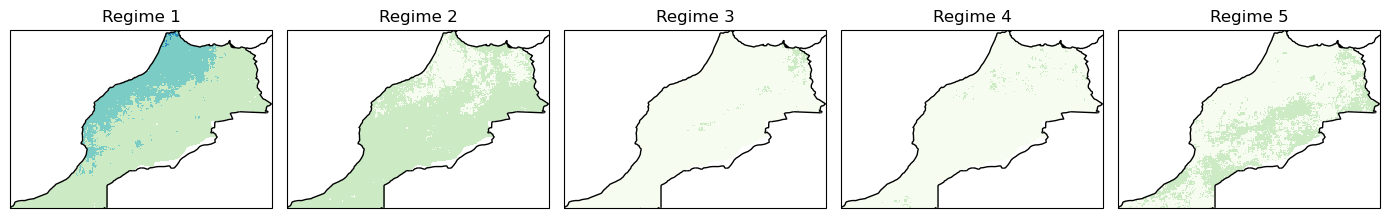

In [39]:
k=5

labels = pd.read_csv(filepath_pca_kmeans+'cluster_labels_'+str(k)+'_preciporder.csv')['label'].values

pr_qn95_ratio = cf.calculate_conditional_probability_change_label(threshold_matrix = threshold_qn95, 
                                                        labels=labels,
                                                       comparison = 'ratio', shift_value=0)

pr_qn95_vis = cf.visualise_spatial_oddsratio_8(dataset_xarray = pr_qn95_ratio, unit='', 
                               color_scheme = 'GnBu', vmin = 0, vmax=5, steps=6, 
                               title = 'Odds ratio of 95th percentile precipitation',
                                         regime_names = ['Regime 1', 'Regime 2', 'Regime 3',
                                                                     'Regime 4', 'Regime 5', 'Regime 6',
                                                                     'Regime 7', 'Regime 8', 'Regime 9', 'Regime 10'],
                               borders=True, projection=ccrs.PlateCarree(central_longitude=0),
                                          col_number=k)#

plt.savefig(filepath_pca_kmeans+'precip_odds_ratio_'+str(k)+'_preciporder_newscale.png')